### Visualising the latent space
#### Focussed on the example demonstrating the model has generalised lymph node growth.
##### This notebook is used to visualise the latent space of the VAE model. The latent space is a 400-dimensional space that represents the features of the input images. We can modify the latent space to generate new images that are similar to the original images but have different features. This can be used to understand the features that the model has learned and how they affect the generated images.

In [4]:
import numpy as np
import os
import sys
import math
from time import perf_counter
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, confusion_matrix
from scipy.spatial.distance import cdist
from hyperopt import hp, fmin, tpe, Trials
import nibabel as nib
import wandb
import random
import pickle
from torchvision import transforms
import cv2


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.datasets import Load_Latent_Vectors, LoadImages, prepare_VAE_MLP_joint_data
from utils.utility_code import get_single_scan_file_list, get_class_distribution, weights_init, plot_MLP_results, error_analysis
from models.MLP_model import MLP_MIL_model_simple, MLP_MIL_model2
from models.VAE_2D_model import VAE_2D
from utils.train_and_test_functions import mixup_patient_data, mixup_batch, process_batch_with_noise, calibration_curve_and_distribution

def patient_test_data(patient_id):
    add_images = True
    indices = patient_slices_dict[patient_id]
    if len(indices) > max_node_slices:
        mask_sizes = mask_sizes[patient_id]
        sizes = sorted(enumerate(mask_sizes), key=lambda x: x[1], reverse=True)
        biggest_n_mask_idx = [i for i, size in sizes[:self.max_nodes]]
        indices = sorted([indices[i] for i in biggest_n_mask_idx])

    # add clinical data to the latent vectors
    patient_indicator = False
    patient_options = []
    if "patient" in clinical_data_options:
        patient_indicator = True
        patient_options.append('age_scaled')
        patient_options.append('sex_numeric')
    if "T_stage" in clinical_data_options:
        patient_indicator = True
        patient_options.append('TumourLabel_numeric')

    if patient_options == []:
        patient_clinical_data = None
    else:
        patient_clinical_data = cohort1[cohort1['shortpatpseudoid'] == patient_id.split('_')[0]][patient_options].values.tolist()

    with open(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\border_metrics.pkl", 'rb') as f:
        compactness, convexity = pickle.load(f)

    LN_features = []
    images = np.zeros((len(indices), 1, 32, 32))
    for i, index in enumerate(indices):
        file_name = all_files_list[index]
        pat_id = patient_id.split('_')[0]
        node_number = float(file_name.split('//')[1].split('_')[6])
        # print(file_name, node_number)
        long, short, ratio = short_long_axes_dict[pat_id][node_number]
        mask_file = file_name.replace('mri', 'mask')
        # compactness = compactness[mask_file]
        # convexity = convexity[mask_file]
        # print(long, short, ratio, compactness, convexity)

        node_indicator = False
        node_options = []
        if "size" in clinical_data_options:
            node_indicator = True
            node_options.append(long)
            node_options.append(short)
            node_options.append(ratio)
        # if "border" in clinical_data_options:
        #     node_indicator = True
        #     node_options.append(compactness)
        #     node_options.append(convexity)

        LN_features.append(node_options)

        transform = transforms.Compose([transforms.ToTensor()])
        img_dir = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices/"
        img = nib.load(img_dir + file_name).get_fdata()
        img = transform(img)
        images[i] = img


    LN_features = np.array(LN_features)
    if patient_indicator == True and ("size" in clinical_data_options):
        patient_clinical_data = patient_clinical_data[0] + LN_features[np.argmax(LN_features[:, 0])].tolist() # add the data for node with max long axis ratio (and corresponding short/ratio/compactness/convexity) to patient level clinical data
    if patient_indicator == True and ("border" in clinical_data_options) and ("size" not in clinical_data_options):
        patient_clinical_data = patient_clinical_data[0] + LN_features[np.argmin(LN_features[:, 0])].tolist() # add min compactness node data to patient level clinical data
    if patient_indicator == True and node_indicator == False:
        patient_clinical_data = patient_clinical_data[0]
    if patient_indicator == False and node_indicator == True:
        if "size" in clinical_data_options:
            patient_clinical_data = LN_features[np.argmax(LN_features[:, 0])].tolist()
        if ("border" in clinical_data_options) and ("size" not in clinical_data_options):
            patient_clinical_data = LN_features[np.argmin(LN_features[:, 0])].tolist()
    if patient_indicator == False and node_indicator == False:
        patient_clinical_data = []

    label = patient_labels_dict[patient_id]

    if add_images == True:
        number_of_nodes = len(images)
        if len(images) < max_node_slices:
            #print(LN_features.shape, label, patient_clinical_data, number_of_nodes)
            images = np.concatenate((images, np.zeros((max_node_slices - len(images), 1, 32, 32))), axis=0)
            LN_features = np.concatenate((LN_features, np.ones((max_node_slices - len(LN_features), LN_features.shape[1]))*0.5), axis=0)
            #print(images.shape, LN_features.shape)

        return torch.tensor(LN_features, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(patient_clinical_data, dtype=torch.float32), torch.tensor(number_of_nodes, dtype=torch.float32), torch.tensor(images, dtype=torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")
latent_vectors = np.load(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\latent_vectors_36.npy")

all_files_list = ['\mri' + '//' + f for f in os.listdir(IMAGE_DIR + '\mri')] + ['\mri_aug' + '//' + f  for f in os.listdir(IMAGE_DIR + '\mri_aug')]
all_files_list.sort()
all_files_list = get_single_scan_file_list(all_files_list, IMAGE_DIR, cohort1)


VAE_params_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\VAE_36.pt"
checkpoint = torch.load(VAE_params_path)
train_test_split_dict = checkpoint['train_test_split']
train_ids = train_test_split_dict['train']
test_ids = train_test_split_dict['test']
hyperparams = checkpoint['hyperparams']
vae_model = VAE_2D(hyperparams)
vae_model = vae_model.to(device)
# Load the saved checkpoint
vae_model.load_state_dict(checkpoint["state_dict"])
# Put the model into evaluation mode if you're not training anymore
vae_model.eval()
encoder = vae_model.encoder


mlp_checkpoint = torch.load(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\MLP_Results\best_model\MLP_62.pt")
mlp_hyperparams = mlp_checkpoint['hyperparams']
print(mlp_hyperparams)
clinical_data_options = mlp_hyperparams['clinical_data_options']
clinical_length = 0
if "size" in clinical_data_options:
    clinical_length += 3
if "border" in clinical_data_options:
    clinical_length += 2
print("clinical_length", clinical_length)
mlp_model = MLP_MIL_model2(patch_input_dim=400+clinical_length, hyperparams=mlp_hyperparams, grad_cam=True)
mlp_model = mlp_model.to(device)
mlp_model.load_state_dict(mlp_checkpoint["state_dict"])
mlp_model.eval()

max_node_slices = mlp_hyperparams['max_node_slices']
n_synthetic = 0
oversample = 1



first_time = False
if first_time:
    patient_slices_dict, patient_labels_dict, patient_file_names_dict, short_long_axes_dict, mlp_train_ids, test_ids, mlp_train_labels, test_labels, train_images, test_images, train_test_split_dict, mask_sizes = prepare_VAE_MLP_joint_data(first_time_train_test_split=False, train_ids=train_ids, test_ids=test_ids, num_synthetic=n_synthetic, oversample_ratio=oversample)
    data_dictionaries = {"slices": patient_slices_dict, "labels": patient_labels_dict, "files": patient_file_names_dict, "sizes": short_long_axes_dict, "mask_sizes": mask_sizes, "mlp_train_ids": mlp_train_ids, "test_ids": test_ids, "mlp_train_labels": mlp_train_labels, "test_labels": test_labels, "train_images": train_images, "test_images": test_images, "train_test_split_dict": train_test_split_dict}
    torch.save(data_dictionaries, r'C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\MLP_Results\data_dictionaries.pth')
else:
    data_dictionaries = torch.load(r'C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\MLP_Results\data_dictionaries.pth')
    patient_slices_dict = data_dictionaries["slices"]
    patient_labels_dict = data_dictionaries["labels"]
    patient_file_names_dict = data_dictionaries["files"]
    short_long_axes_dict = data_dictionaries["sizes"]
    mask_sizes = data_dictionaries["mask_sizes"]
    mlp_train_ids = data_dictionaries["mlp_train_ids"]
    test_ids = data_dictionaries["test_ids"]
    mlp_train_labels = data_dictionaries["mlp_train_labels"]
    test_labels = data_dictionaries["test_labels"]
    train_images = data_dictionaries["train_images"]
    test_images = data_dictionaries["test_images"]
    train_test_split_dict = data_dictionaries["train_test_split_dict"]

{'num_epochs': 200, 'threshold': 0.42464394114347515, 'num_synthetic': 25, 'oversample': 1.25, 'batch_size': 150, 'lr': 0.006957631081085049, 'weight_decay': 0.08706146849970067, 'accumulation_steps': 4, 'patch_hidden_dim': 2048, 'patient_hidden_dim': 128, 'patch_dropout': 0.4, 'patient_dropout': 0.3, 'alpha': 0.8, 'mixup': False, 'attention_indicator': False, 'max_node_slices': 25, 'model_type': 'MLP_MIL_model2', 'clinical_data_options': ['T_stage', 'size', 'patient'], 'device': device(type='cuda')}
clinical_length 3


Patient ID: BCCF032054 Patient index: 0
0.5 tensor(0.9561) Total small: 2 Total large circle: 0 Total large oval: 0
Patient ID: 7FC2A02F61 Patient index: 1
circle tensor([0.5019, 0.5700, 0.9552])
circle tensor([0.5019, 0.5700, 0.9552])
0.5 tensor(1.0000) Total small: 10 Total large circle: 2 Total large oval: 0
Patient ID: 57D9738117 Patient index: 2
0.5 tensor(1.0000) Total small: 12 Total large circle: 2 Total large oval: 0
Patient ID: B9D8863366 Patient index: 3
0.5 tensor(1.0000) Total small: 12 Total large circle: 2 Total large oval: 0
Patient ID: BC32626973 Patient index: 4
0.5 tensor(1.0000) Total small: 16 Total large circle: 2 Total large oval: 0
Patient ID: 9872B559B8 Patient index: 5
0.5 tensor(1.0000) Total small: 21 Total large circle: 2 Total large oval: 0
Patient ID: 9FFF37F519 Patient index: 6
0.5 tensor(1.0000) Total small: 21 Total large circle: 2 Total large oval: 0
Patient ID: F7C346CFF8 Patient index: 7
0.5 tensor(1.0000) Total small: 23 Total large circle: 2 Total

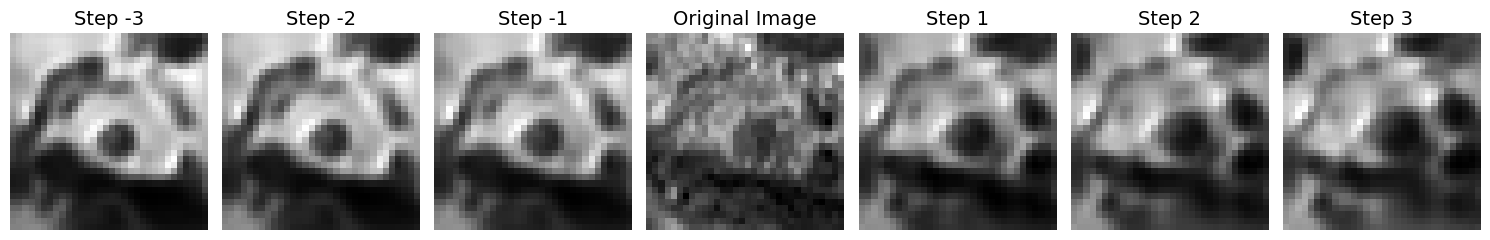

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 16 Images shape: torch.Size([1, 32, 32])


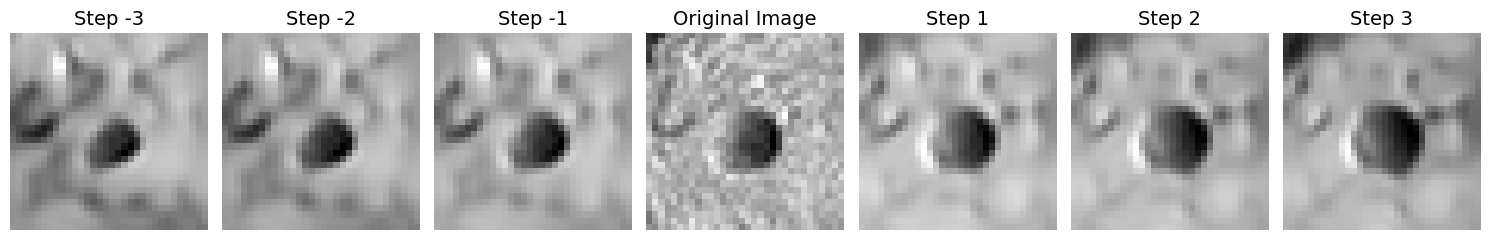

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


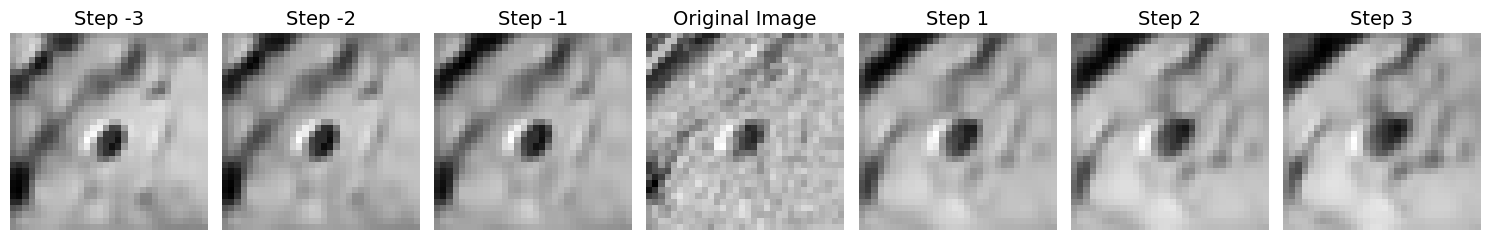

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


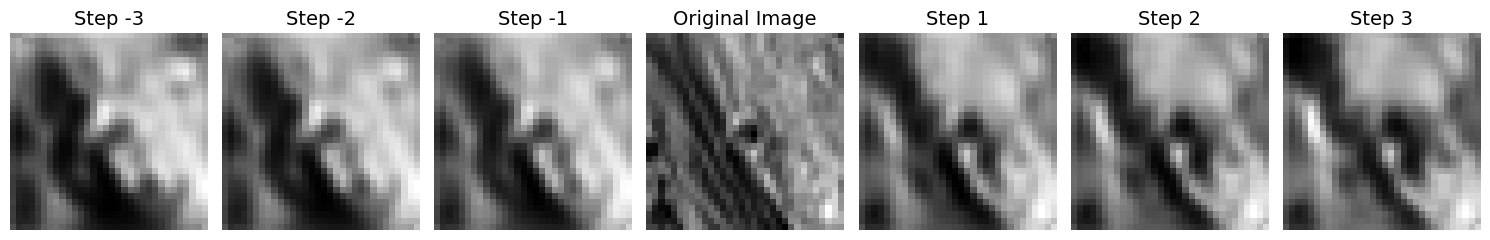

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 5 Images shape: torch.Size([1, 32, 32])


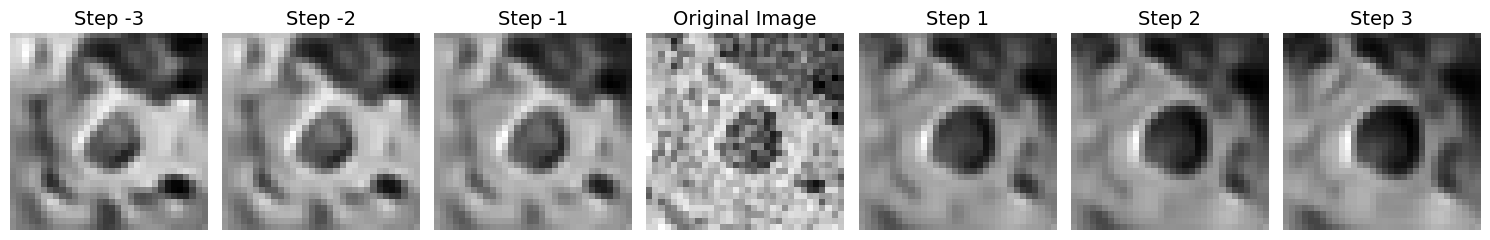

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 1 Images shape: torch.Size([1, 32, 32])


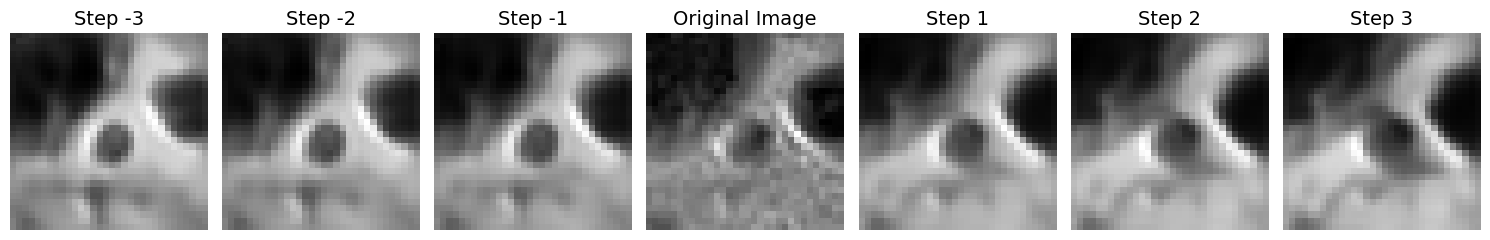

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


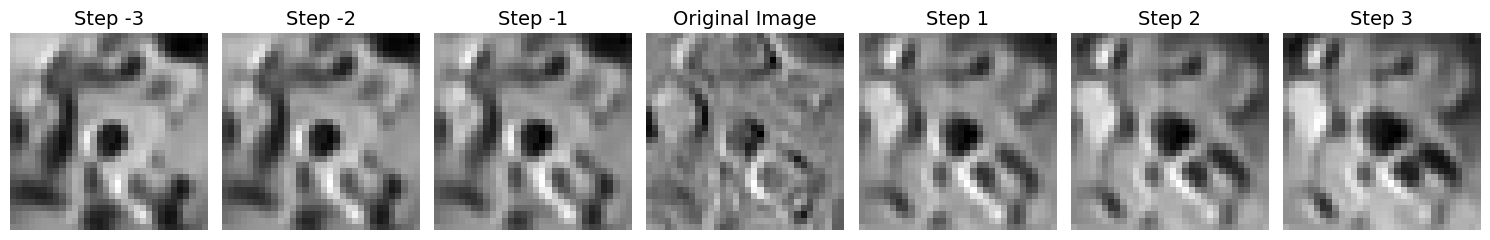

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


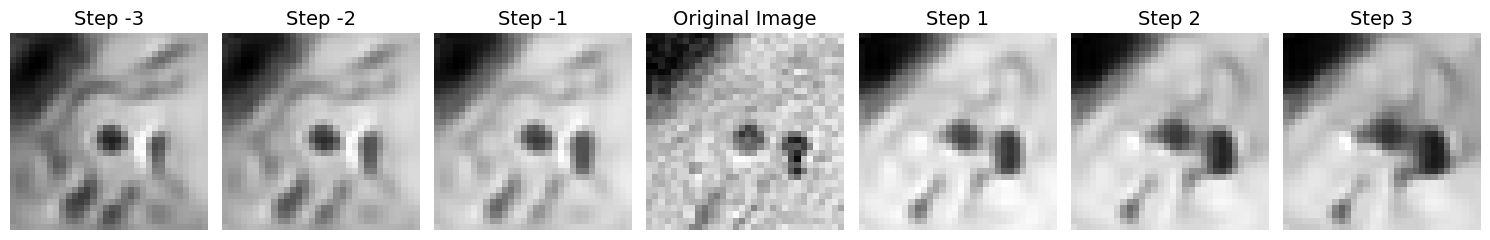

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 12 Images shape: torch.Size([1, 32, 32])


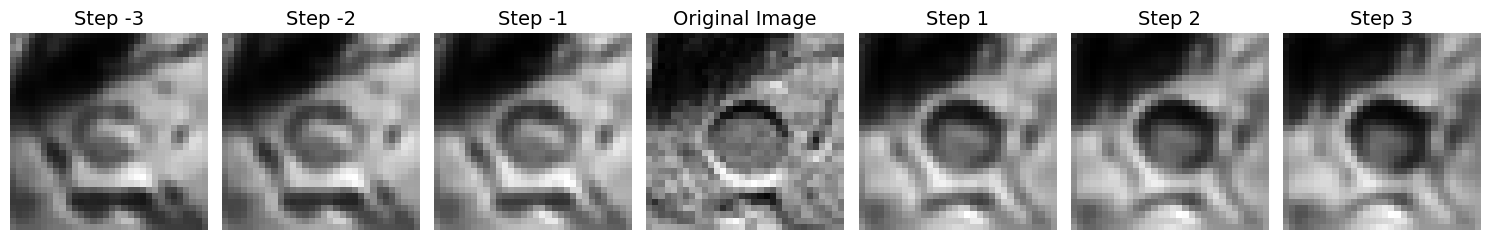

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 5 Images shape: torch.Size([1, 32, 32])


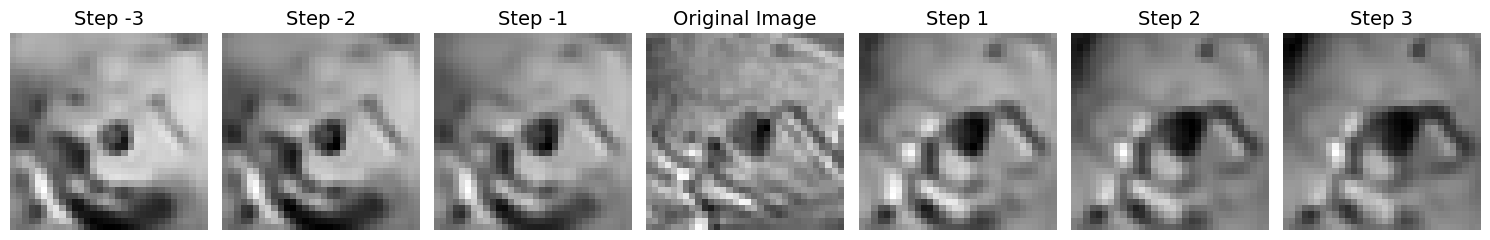

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


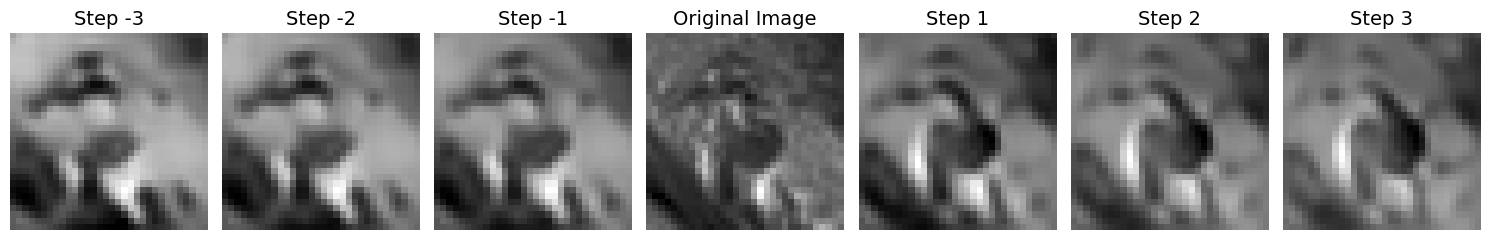

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 3 Images shape: torch.Size([1, 32, 32])


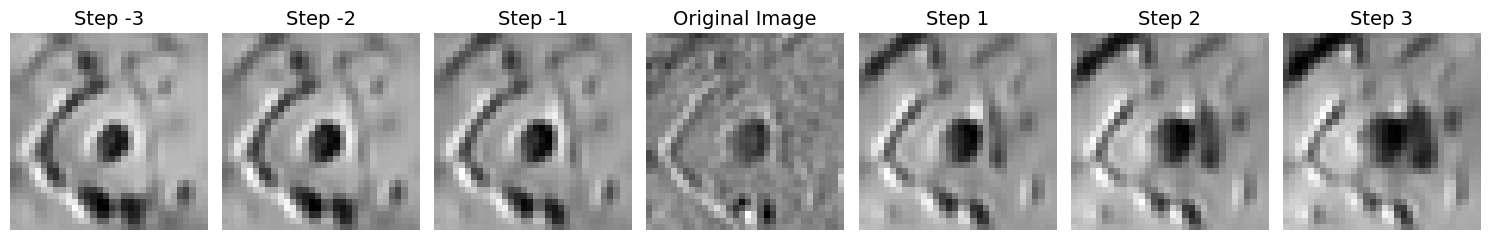

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 3 Images shape: torch.Size([1, 32, 32])


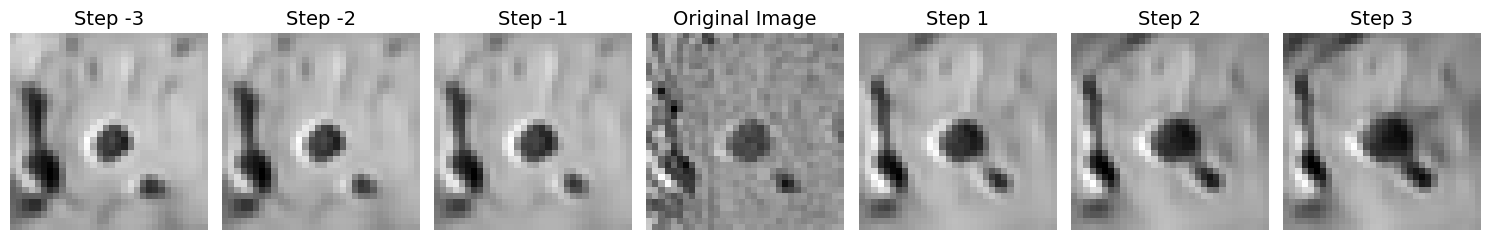

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 4 Images shape: torch.Size([1, 32, 32])


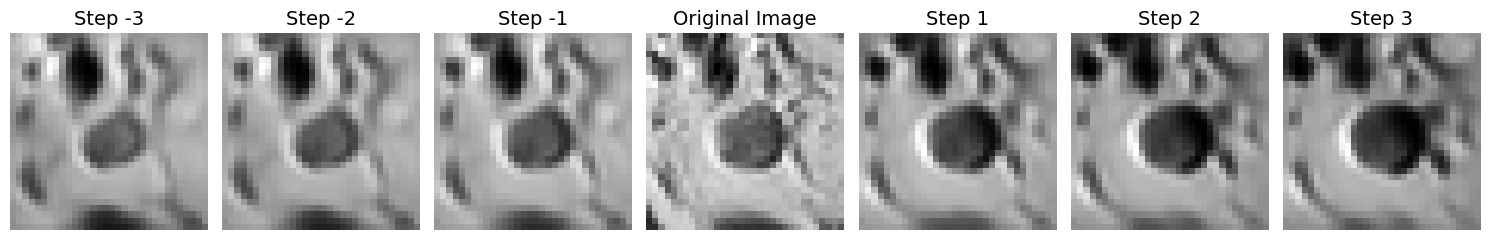

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 5 Images shape: torch.Size([1, 32, 32])


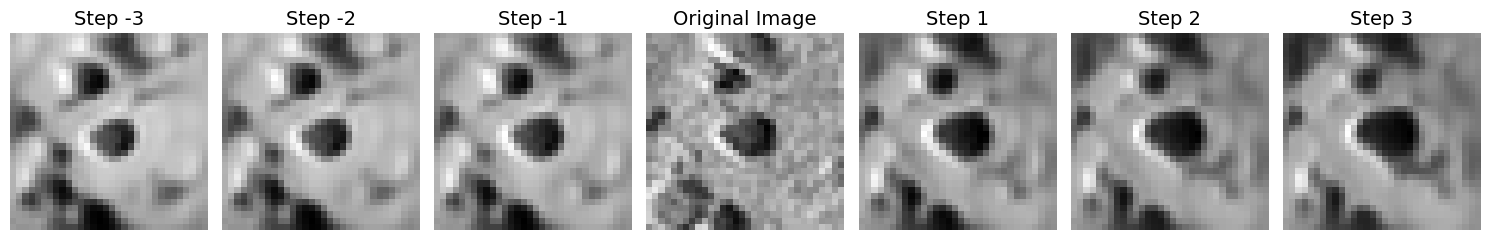

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 2 Images shape: torch.Size([1, 32, 32])


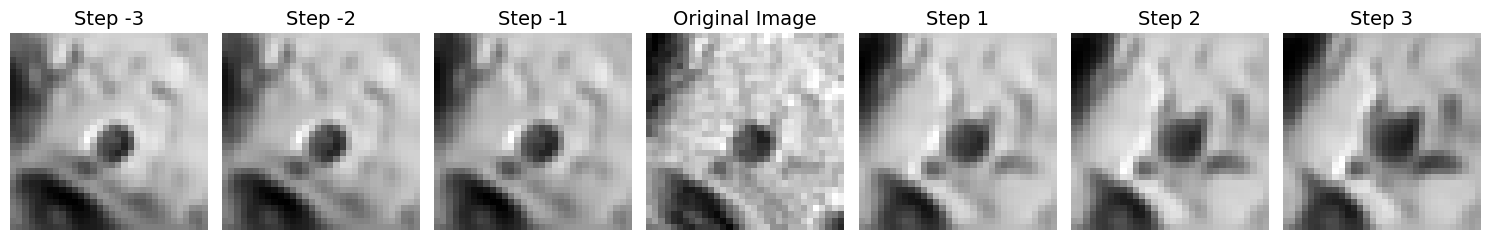

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 21 Images shape: torch.Size([1, 32, 32])


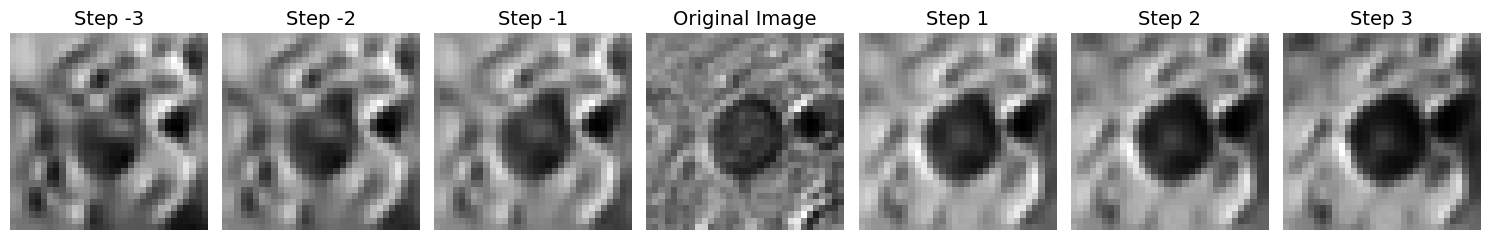

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 6 Images shape: torch.Size([1, 32, 32])


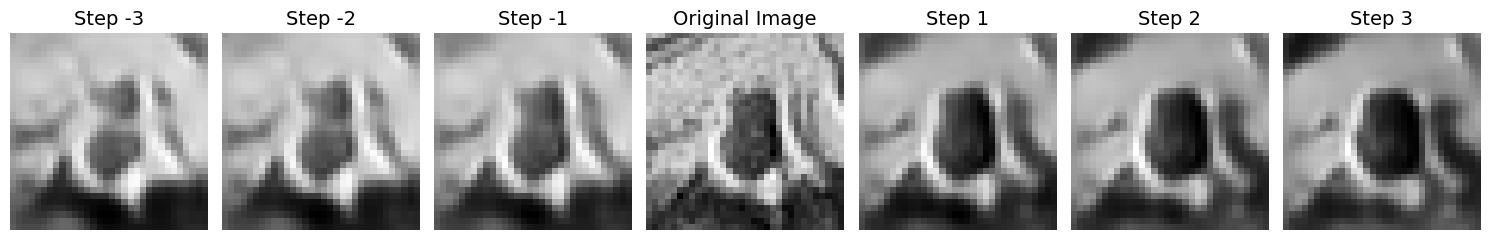

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 2 Images shape: torch.Size([1, 32, 32])


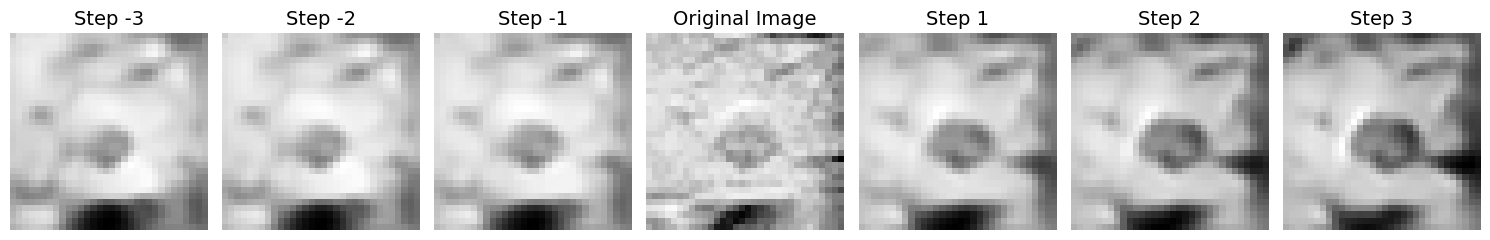

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 1 Images shape: torch.Size([1, 32, 32])


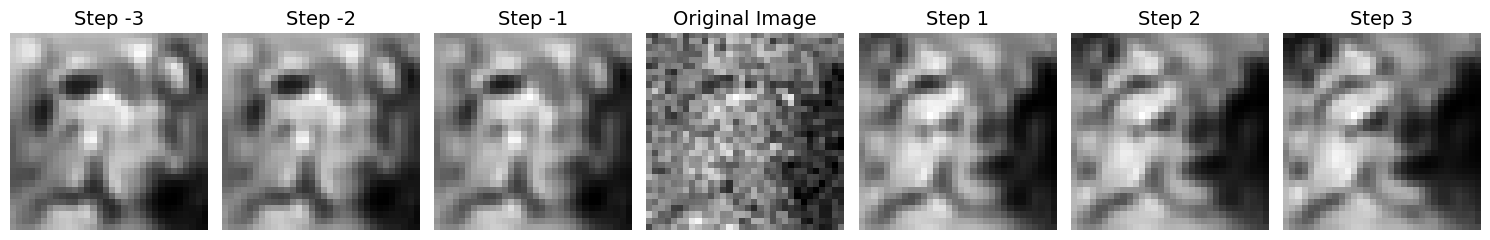

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


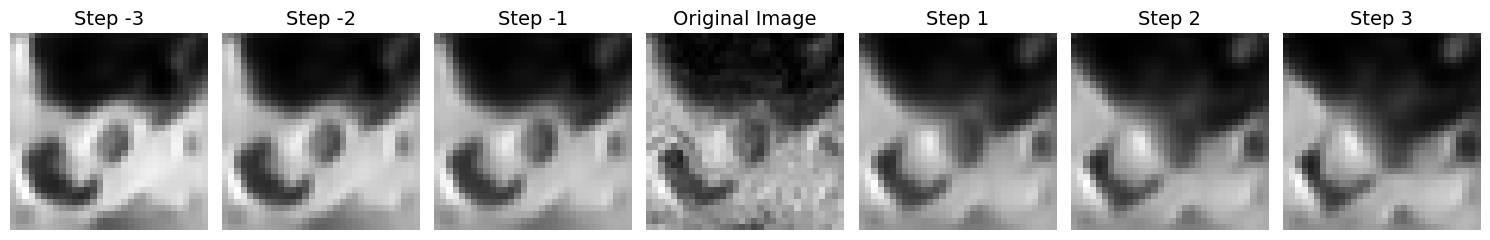

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 5 Images shape: torch.Size([1, 32, 32])


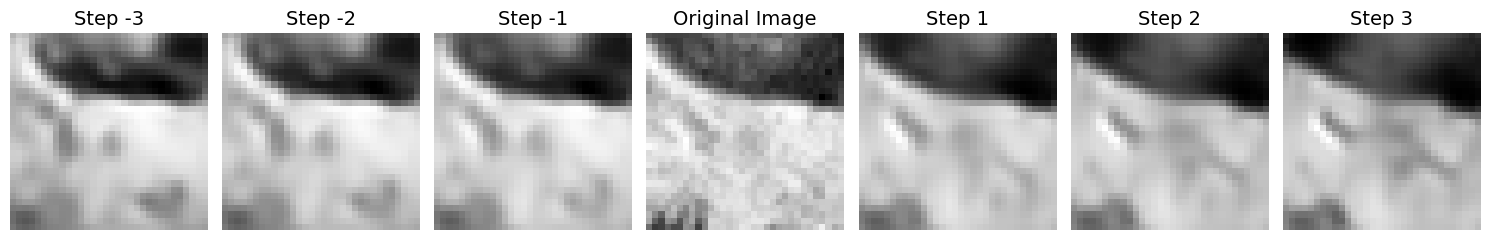

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


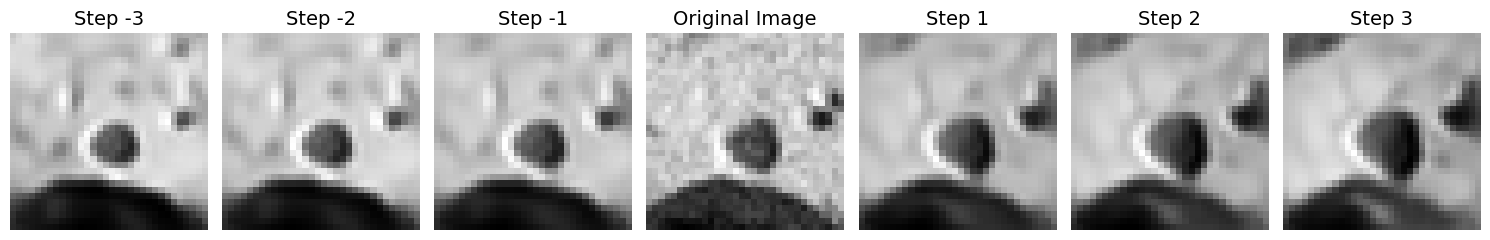

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 2 Images shape: torch.Size([1, 32, 32])


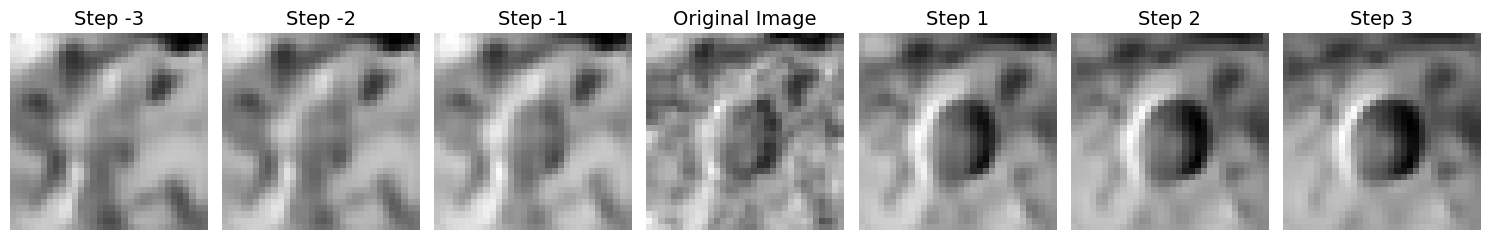

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


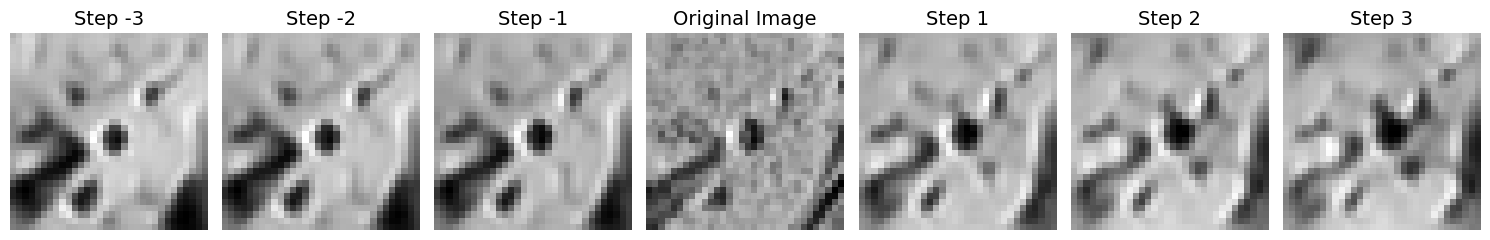

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 1 Images shape: torch.Size([1, 32, 32])


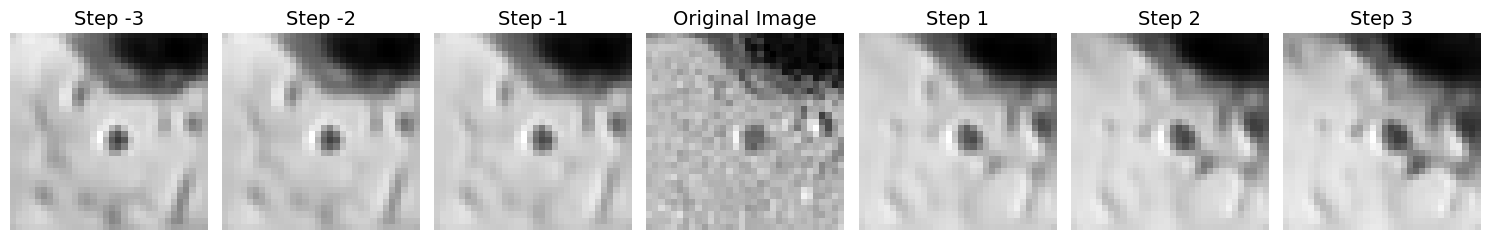

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 2 Images shape: torch.Size([1, 32, 32])


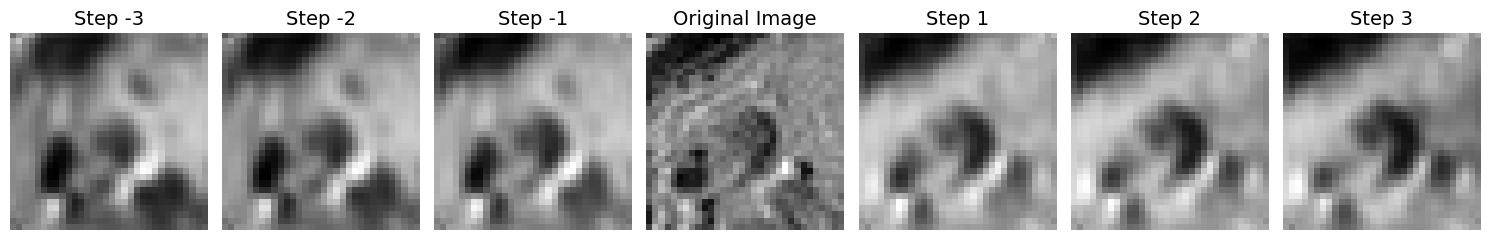

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 3 Images shape: torch.Size([1, 32, 32])


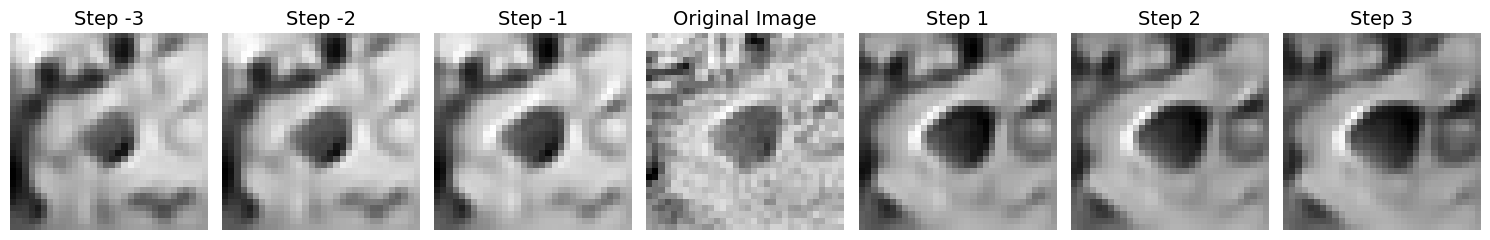

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 7 Images shape: torch.Size([1, 32, 32])


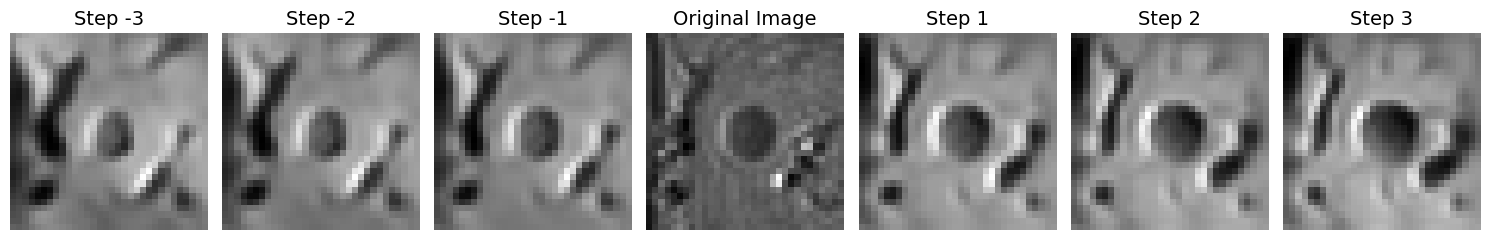

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 0 Images shape: torch.Size([1, 32, 32])


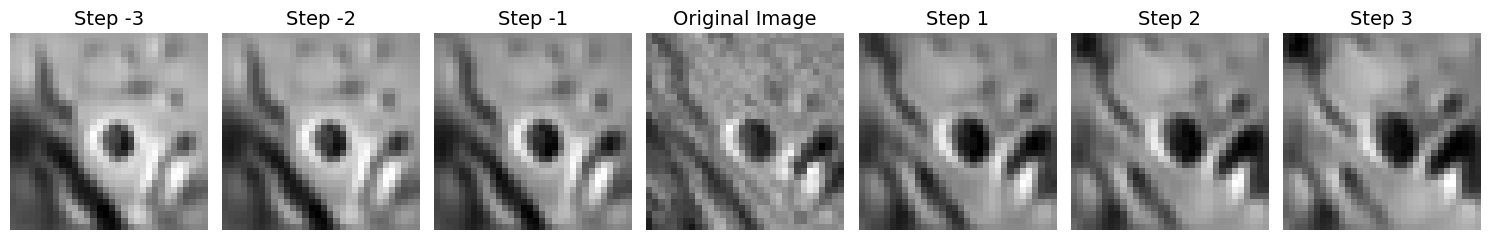

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 1 Images shape: torch.Size([1, 32, 32])


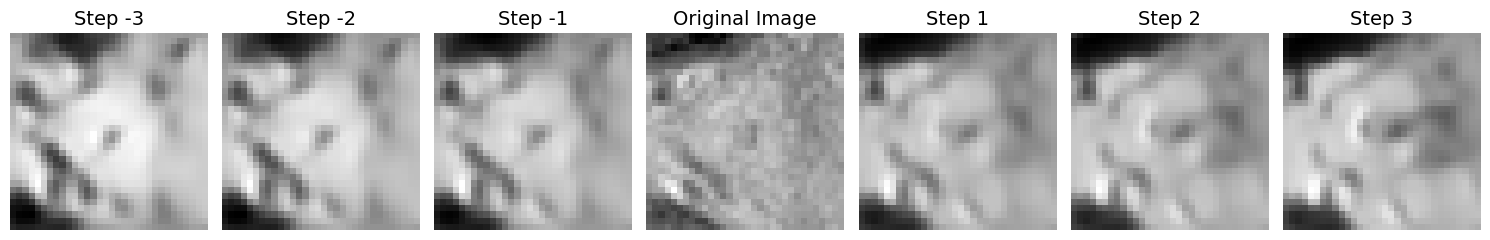

Random mu shape: torch.Size([1, 400, 1, 1]) Random index: 3 Images shape: torch.Size([1, 32, 32])


KeyboardInterrupt: 

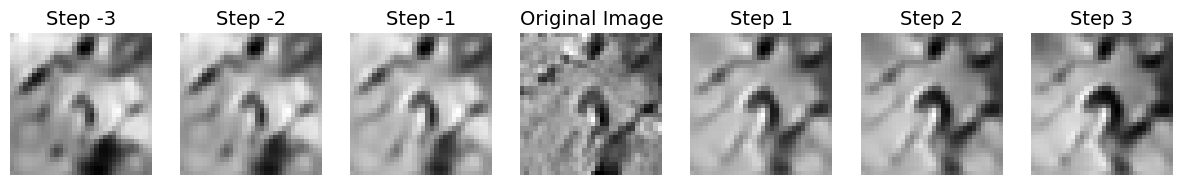

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Important latent variable indices to modify
latent_interest = [84, 187, 70, 53, 172, 270, 0, 271, 272, 269, 178, 36]  # Indices of latent variables

# Set up the number of rows and columns for subplots
n_steps = 3  # Number of steps in both positive and negative directions
n_cols = n_steps * 2 + 1  # Original + n_steps positive + n_steps negative
n_rows = 1  # One row for each latent variable modified
mus = []  # List to store modified mus

# Initialize lists to store latent representations
small_mus = []
large_circle_mus = []
large_oval_mus = []
total_small = 0
total_large_circle = 0
total_large_oval = 0
min_ratio, max_ratio = 0.5, 0.5

# First loop to gather mus
for patient_idx, id in enumerate(train_ids):
    if patient_idx == 42:
        continue

    print('Patient ID:', train_ids[patient_idx], 'Patient index:', patient_idx)

    # Load patient data
    LN_features, label, clinical_data, num_nodes, images = patient_test_data(train_ids[patient_idx])
    images = images.float().to(device)

    # Get the mu from the encoder
    mu = vae_model.encoder_mu(vae_model.encoder(images))
    mu = mu.detach()

    for i, LN in enumerate(LN_features):
        if LN[2] > max_ratio:
            max_ratio = LN[2]
        if LN[2] < min_ratio:
            min_ratio = LN[2]
        if LN[0] > 0.5 and LN[2] > 0.9:
            large_circle_mus.append(mu[i])
            print('circle', LN)
            total_large_circle += 1
        if LN[0] > 0.5 and LN[2] < 0.9:
            large_oval_mus.append(mu[i])
            print('oval', LN)
            total_large_oval += 1
        if 0.1 < LN[0] < 0.3:
            small_mus.append(mu[i])
            total_small += 1

    print(min_ratio, max_ratio, 'Total small:', total_small,
          'Total large circle:', total_large_circle,
          'Total large oval:', total_large_oval)

# Calculate the averages
large_circle_mu = torch.mean(torch.stack(large_circle_mus), dim=0)
large_oval_mu = torch.mean(torch.stack(large_oval_mus), dim=0)
small_mu = torch.mean(torch.stack(small_mus), dim=0)
print('Large circle mu:', large_circle_mu.shape,
      'Large oval mu:', large_oval_mu.shape,
      'Small mu:', small_mu.shape)

# Calculate direction
direction = large_circle_mu - large_oval_mu

examples = [6, 12, 14, 33, 37, 41, 43, 21]

# Loop through patient examples again for random images
for patient_idx, id in enumerate(train_ids):
#for patient_idx in examples:
    #if patient_idx == 42:
    #    continue

    # Create a new figure for each patient
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))  # Adjust height based on rows

    # Ensure axes is a flat array if n_rows = 1
    if n_rows == 1:
        axes = axes.flatten()

    # Load patient data
    LN_features, label, clinical_data, num_nodes, images = patient_test_data(train_ids[patient_idx])
    images = images.float().to(device)

    # Get the mu from the encoder
    mu = vae_model.encoder_mu(vae_model.encoder(images))
    mu = mu.detach()

    # Select a random index for modification
    #random_idx = random.randint(0, num_nodes.squeeze().item() - 1)
    node_features = LN_features.detach().cpu().numpy()
    node_features = node_features[:int(num_nodes.squeeze().item()), :]
    max_node_index = np.argmax(node_features[:, 0])
    random_idx = max_node_index
    mu = mu[random_idx].unsqueeze(dim=0)
    images = images.detach()[random_idx]

    print('Random mu shape:', mu.shape,
          'Random index:', random_idx,
          'Images shape:', images.shape)

    # Check if images are valid before plotting
    if images.numel() > 0:
        # Show original reconstruction
        axes[n_steps].imshow(images.squeeze().cpu().detach().numpy(), cmap='gray')
        axes[n_steps].set_title("Original Image", fontsize=14)
        axes[n_steps].axis('off')

        # Apply the direction vector in positive and negative steps
        for i, step in enumerate([3, 2, 1]):
            # Modify the mu for positive direction
            modified_mu_positive = mu.clone() - direction * step * 0.75
            modified_recons_positive = vae_model.decoder(modified_mu_positive).squeeze()
            axes[i].imshow(modified_recons_positive.cpu().detach().numpy(), cmap='gray')
            axes[i].set_title(f"Step -{step}", fontsize=14)
            axes[i].axis('off')
        for i, step in enumerate([1, 2, 3]):
            # Modify the mu for negative direction
            modified_mu_negative = mu.clone() + direction * step * 0.75
            modified_recons_negative = vae_model.decoder(modified_mu_negative).squeeze()
            axes[i + n_steps + 1].imshow(modified_recons_negative.cpu().detach().numpy(), cmap='gray')
            axes[i + n_steps + 1].set_title(f"Step {step}", fontsize=14)
            axes[i + n_steps + 1].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
        plt.show()  # Display all reconstructions
    else:
        print(f"Images for patient {train_ids[patient_idx]} are empty.")
